In [12]:
from molmap import dataset
from molmap import loadmap
import molmap

import matplotlib.pyplot as plt
from joblib import dump, load
from tqdm import tqdm
import pandas as pd
tqdm.pandas(ascii=True)

import numpy as np
import tensorflow as tf


#use the second GPU, if negative value, CPUs will be used
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"


%matplotlib inline
np.random.seed(777)
tf.set_random_seed(777)

In [13]:
def get_deepchem_idx(df):
    """ deepchem dataset"""
    deepchem_data_name = './ClinTox_deepchem.data'
    if os.path.exists(deepchem_data_name):
        train_df,valid_df,test_df = load(deepchem_data_name)
    else:
        import deepchem as dc
        task, train_valid_test, _ = dc.molnet.load_ClinTox(featurizer='Raw',split = 'random')
        train, valid, test = train_valid_test
        train_df = df[df.smiles.isin(train.ids)]
        valid_df = df[df.smiles.isin(valid.ids)]
        test_df = df[df.smiles.isin(test.ids)]
        dump((train_df,valid_df,test_df), deepchem_data_name)
    train_idx = train_df.index
    valid_idx = valid_df.index
    test_idx = test_df.index
    print('training set: %s, valid set: %s, test set %s' % (len(train_idx), len(valid_idx), len(test_idx)))
    return train_idx, valid_idx, test_idx


def get_attentiveFP_idx(df):
    """ attentiveFP dataset"""
    train, valid,test = load('./ClinTox_attentiveFP.data')
    train_idx = df[df.smiles.isin(train.smiles)].index
    valid_idx = df[df.smiles.isin(valid.smiles)].index
    test_idx = df[df.smiles.isin(test.smiles)].index
    print('training set: %s, valid set: %s, test set %s' % (len(train_idx), len(valid_idx), len(test_idx)))
    return train_idx, valid_idx, test_idx 


def get_pos_weights(trainY):
    """pos_weights: neg_n / pos_n """
    dfY = pd.DataFrame(trainY)
    pos = dfY == 1
    pos_n = pos.sum(axis=0)
    neg = dfY == 0
    neg_n = neg.sum(axis=0)
    pos_weights = (neg_n / pos_n).values
    neg_weights = (pos_n / neg_n).values
    return pos_weights, neg_weights

#load dataset
data = dataset.load_ClinTox()
df = data.data

total samples: 1484


In [14]:
MASK = -1
Y = pd.DataFrame(data.y).fillna(MASK).values

In [15]:
# calculate feature
X1_name =  './descriptor_grid_split.data'
X2_name =  './fingerprint_grid_split.data'

if os.path.exists(X1_name):
    X1 = load(X1_name)
else:
    mp1 = loadmap('../../descriptor_grid_split.mp')
    X1 = mp1.batch_transform(data.x, n_jobs = 8)
    dump(X1, X1_name)
    

if os.path.exists(X2_name):
    X2 = load(X2_name)
else:
    mp2 = loadmap('../../fingerprint_grid_split.mp')
    X2 = mp2.batch_transform(data.x, n_jobs = 8)
    dump(X2, X2_name)

In [16]:
train_idx, valid_idx, test_idx = get_attentiveFP_idx(df)
#train_idx, valid_idx, test_idx = get_deepchem_idx(df)


trainX = X1[train_idx]
trainY = Y[train_idx]

validX = X1[valid_idx]
validY = Y[valid_idx]

testX = X1[test_idx]
testY = Y[test_idx]

print(len(train_idx), len(valid_idx), len(test_idx))


training set: 1180, valid set: 148, test set 148
1180 148 148


In [17]:
from loss import cross_entropy, weighted_cross_entropy
from cbks import EarlyStoppingAndPerformance
from model import SinglePathClassificationModel, DoublePathClassificationModel

earlystop = EarlyStoppingAndPerformance((trainX, trainY), (validX, validY), MASK, patience=10, criteria = 'val_loss')
lr = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #
molmap1_size = X1.shape[1:]
pos_weights, neg_weights = get_pos_weights(trainY)
loss = lambda y_true, y_pred: weighted_cross_entropy(y_true,y_pred, pos_weights, MASK)
model = SinglePathClassificationModel(molmap1_size, n_outputs = Y.shape[1])
model.compile(optimizer = lr, loss = cross_entropy)

In [18]:
model.count_params()

403490

In [19]:
model.fit(trainX, trainY, batch_size=128, 
      epochs=500, verbose= 0, shuffle = True, 
      validation_data = (validX, validY), 
      callbacks=[earlystop]) 

epoch: 0001, loss: 0.5646 - val_loss: 0.4703; auc: 0.5060 - val_auc: 0.4592                                                                                                    
epoch: 0002, loss: 0.3598 - val_loss: 0.3561; auc: 0.5151 - val_auc: 0.4547                                                                                                    
epoch: 0003, loss: 0.2596 - val_loss: 0.3848; auc: 0.5551 - val_auc: 0.4973                                                                                                    
epoch: 0004, loss: 0.2593 - val_loss: 0.3837; auc: 0.5942 - val_auc: 0.5306                                                                                                    
epoch: 0005, loss: 0.2542 - val_loss: 0.3622; auc: 0.6426 - val_auc: 0.5715                                                                                                    
epoch: 0006, loss: 0.2521 - val_loss: 0.3566; auc: 0.6777 - val_auc: 0.6094                                             

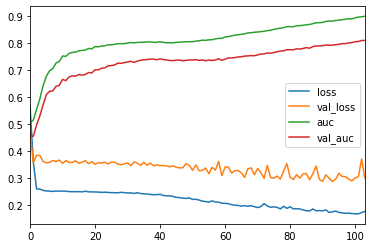

In [20]:
dfp = pd.DataFrame(earlystop.history)[['loss', 'val_loss', 'auc', 'val_auc']]
dfp.plot()

In [21]:
train_auc = np.mean(earlystop.evaluate(trainX, trainY))
valid_auc = np.mean(earlystop.evaluate(validX, validY))
test_auc = np.mean(earlystop.evaluate(testX, testY))


print(train_auc, valid_auc, test_auc)

0.8827377197194872 0.7934862453395655 0.9858776340996169


In [22]:
earlystop.evaluate(testX, testY)

[0.9839080459770115, 0.9878472222222222]